# Imports

In [1]:
!pip install concise

     |████████████████████████████████| 1.3MB 3.4MB/s 
     |████████████████████████████████| 317kB 19.1MB/s 
     |████████████████████████████████| 51kB 7.0MB/s 
  Created wheel for gtfparse: filename=gtfparse-1.2.1-cp36-none-any.whl size=11639 sha256=be93e45b81fa78aa5a5c5fc489e11e693b435ec781158c07fbafe5b0bc597559
  Stored in directory: /root/.cache/pip/wheels/e2/74/a0/92c0c82fe374f6bfc3e4224c1fd4be6ae5529e11366dd9e874
Successfully built gtfparse
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive 

Mounted at /gdrive
/gdrive


In [3]:
cd /gdrive/My\ Drive/nn 

/gdrive/My Drive/nn


In [4]:
%tensorflow_version 1.x
import argparse
import os
import pickle
import glob
import sys

import numpy as np

np.random.seed(7)  # for reproducibility

import tensorflow as tf
tf.random.set_random_seed(5005)

from sklearn.model_selection import train_test_split, KFold


from tensorflow.python.keras.models import Model, load_model
from tensorflow.python.keras.layers import Input
from tensorflow.python.keras.layers import Dense, Flatten, Dropout
from tensorflow.python.keras.layers.convolutional import Conv1D
from tensorflow.python.keras.layers.pooling import MaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow.python.keras.backend as K


import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn')
mpl.use('Agg')
%matplotlib inline

import utils
sys.path.append(".")
import plotseqlogo
import IntegratedGradients
from plotseqlogo import *
from IntegratedGradients import *
from utils import *
from interpretation_exp import *

from tensorflow.python.keras.backend import set_session

CLASS_RESISTANT = 0
CLASS_PRONE = 1 

TensorFlow 1.x selected.


Using TensorFlow backend.
2020-10-06 07:34:01,863 [INFO] Generating grammar tables from /usr/lib/python3.6/lib2to3/Grammar.txt
2020-10-06 07:34:01,888 [INFO] Generating grammar tables from /usr/lib/python3.6/lib2to3/PatternGrammar.txt
/gdrive/My Drive/nn/plotseqlogo.py:37: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  min_coords = np.vstack(data.min(0) for data in polygons_data).min(0)
/gdrive/My Drive/nn/plotseqlogo.py:38: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  max_coords = np.vstack(data.max(0) for data in polygons_data).max(0)


In [5]:
def get_refrence_mean_baseline(current_seq,mean_sequence):
  """
  Get a refrence sequence based on the mean sequences 
  :param: current_seq - The current sequence we are trying to create baseline to
  :param: mean_sequence - The mean value of all sequences
  """
  baseline = current_seq * mean_sequence 
  return baseline


def get_explanations(models, predict_label, rf_mean_sequence, x_sequences, y_labels, number_of_sequences_to_explain=-1, threshold =0.5):
  """
  Get explanations in format of integreated gradients for the different sequences
  :param models: The models to use to get the explanations
  :param predict_label: The label we should predict
  :param rf_mean_sequence: The refrence sequence based on mean of all sequences
  :param x_sequences: x dataset to explain
  :param y_labels: The labels of the dataset
  :param number_of_sequences_to_explain: Number of sequences to explain, -1 mean all
  :param threshold : threshold of prediction to consider this a good sequence 
  :return: The explanation using integrated gradients 
  """
  
  # Need to see if we can do without this 
  # sess = tf.Session()
  # tf.random.set_random_seed(5005)
  # K.set_session(sess)

  # session = K.get_session()
  init = tf.global_variables_initializer()
  # session.run(init)

  true_prediction_index= []
  # with session.as_default():
  #     with session:
  print("predicting")
  model_pred = predict(models, x_sequences)

  model_pred = 1 - model_pred if predict_label ==CLASS_RESISTANT else model_pred

  print("getting sequences")
  for i in sorted(enumerate(model_pred), key=lambda x:x[1],reverse=True):
    if y_labels[i[0]]==predict_label and model_pred[i[0]] > threshold :
      true_prediction_index.append(i[0])
  
  if number_of_sequences_to_explain != -1:
    true_prediction_index = true_prediction_index[:number_of_sequences_to_explain]

  print("getting explanation")
  explanations = []
  for model in models:
    gradients = integrated_gradients(model) 
    model_explanation=np.array([gradients.explain([x_sequences[i]],reference=[get_refrence_mean_baseline(x_sequences[i], rf_mean_sequence)],num_steps=100)[0] for i in true_prediction_index])
    explanations.append(model_explanation)

  combined_explanation = np.array(explanations).mean(axis=0)

  if predict_label == CLASS_RESISTANT:
    combined_explanation = combined_explanation * -1

  return combined_explanation

In [6]:
def get_explanation_for_data(models_folder, data_path, save_path=None, number_of_seq=-1, threshold=0.5,title="zhou", prec=-1):
  """
  Get an explanation in form of integrated gradients for all the test data in data_path using the models 
  :param: models_folder - The path for with all the models 
  :param: data_path - The path of the dataset
  :param: save_path - should we save the gradients to a dictionary for later use 
  """
  # Upload the data and create the refrence sequence based on the mean of all validation and training data
  print("Loading data")
  _,_,_,_, x_test_seq, y_test, x_train, _ = load_train_validate_test_data(data_path, 150, False)
  mean_sequence = x_train.mean(axis=0)

  if prec != -1:
    number_of_seq = int(y_test.shape[0] * prec / 100) + 1

  # Load the models 
  models_paths = glob.glob(os.path.join(models_folder, "*"))
  models = [load_model(model_path, custom_objects={'recall_TP': recall_TP,'recall_TN': recall_TN }) for model_path in models_paths]

  print("Calculating gradients")
  cl_gradients = get_explanations(models, predict_label=CLASS_PRONE, number_of_sequences_to_explain=number_of_seq, threshold=threshold, rf_mean_sequence=mean_sequence, x_sequences=x_test_seq, y_labels=y_test)
  pl_gradients = get_explanations(models, predict_label=CLASS_RESISTANT, number_of_sequences_to_explain=number_of_seq, threshold=threshold, rf_mean_sequence=mean_sequence, x_sequences=x_test_seq, y_labels=y_test)

  if save_path:
    gradients_dictionary = {"hypo-prone": cl_gradients, "hypo-resistant": pl_gradients}

    with open("./gradients_explain/all/graidnets_dictionary_%s.pkl" %title, "wb") as f:
      pickle.dump(gradients_dictionary, f)

  return cl_gradients, pl_gradients

In [7]:
def convert_array_to_sequences(a_array):
  temp = convert_array_hot_encode_to_one_encode(a_array)

  temp2 = temp.astype("str")
  temp2[temp2 == "1"] = "A"
  temp2[temp2 == "2"] = "C"
  temp2[temp2 == "3"] = "G"
  temp2[temp2 == "4"] = "T"
  temp2[temp2 =="0"] = "N"

  return ["".join(i) for i in temp2]


def convert_array_hot_encode_to_one_encode(a_array):
  temp = np.zeros_like(a_array).astype(np.int)
  temp[np.all(a_array==np.array([1,0,0,0]), axis=2)] = np.array([1,0,0,0])
  temp[np.all(a_array==np.array([0,1,0,0]), axis=2)] = np.array([2,0,0,0])
  temp[np.all(a_array==np.array([0,0,1,0]), axis=2)] = np.array([3,0,0,0])
  temp[np.all(a_array==np.array([0,0,0,1]), axis=2)] = np.array([4,0,0,0])
  return temp.sum(axis=2)


In [8]:
zhou_models_folder="./models/zhou"
sc_models_folder="./models/bian"


scgwbs_data = r"dataset/bian_crc01_train_test.pkl"
zhou_all_data = r"dataset/zhou_train_test.pkl"

# Extract gradient for the top 10% of the sequences of all the CpGs in PMD across genome

In [ ]:
def get_explanations_for_all_sequences(models, predict_label, rf_mean_sequence, x_sequences, threshold = 0.5):
  """
  Get explanations in format of integreated gradients for the different sequences
  :param models: The models to use to get the explanations
  :param predict_label: The label we should predict
  :param rf_mean_sequence: The refrence sequence based on mean of all sequences
  :param x_sequences: x dataset to explain
  :param y_labels: The labels of the dataset
  :param number_of_sequences_to_explain: Number of sequences to explain, -1 mean all
  :param threshold : threshold of prediction to consider this a good sequence 
  :return: The explanation using integrated gradients 
  """
  
  # Need to see if we can do without this 
  # sess = tf.Session()
  # tf.random.set_random_seed(5005)
  # K.set_session(sess)

  # session = K.get_session()
  init = tf.global_variables_initializer()
  # session.run(init)

  true_prediction_index= []
  # with session.as_default():
  #     with session:
  print("predicting")
  model_pred = predict(models, x_sequences)

  model_pred = 1 - model_pred if predict_label ==CLASS_RESISTANT else model_pred

  print("getting sequences")
  for i in sorted(enumerate(model_pred), key=lambda x:x[1],reverse=True):
    if model_pred[i[0]] > threshold :
      true_prediction_index.append(i[0])
  
  print("getting explanation")
  explanations = []
  for model in models:
    gradients = integrated_gradients(model) 
    model_explanation=np.array([gradients.explain([x_sequences[i]],reference=[get_refrence_mean_baseline(x_sequences[i], rf_mean_sequence)],num_steps=100)[0] for i in true_prediction_index])
    explanations.append(model_explanation)

  combined_explanation = np.array(explanations).mean(axis=0)

  if predict_label == CLASS_RESISTANT:
    combined_explanation = combined_explanation * -1

  return combined_explanation

In [ ]:
zhou_dataset = "./dataset/zhou_pmds_with_pred_top_bottom_10.pkl"

data = pd.read_pickle(zhou_dataset)

sequences = np.array([seq_to_mat(seq) for seq in data["sequence"]])

_,_,_,_, x_test_seq, y_test, x_train, _ = load_train_validate_test_data(zhou_all_data, 150, False)
mean_sequence = x_train.mean(axis=0)

# Load the models 
models_paths = glob.glob(os.path.join(zhou_models_folder, "*"))
models = [load_model(model_path, custom_objects={'recall_TP': recall_TP,'recall_TN': recall_TN }) for model_path in models_paths]

print("Calculating gradients")
cl_gradients = get_explanations_for_all_sequences(models, predict_label=CLASS_PRONE, rf_mean_sequence=mean_sequence, x_sequences=sequences)
pl_gradients = get_explanations_for_all_sequences(models, predict_label=CLASS_RESISTANT, rf_mean_sequence=mean_sequence, x_sequences=sequences)
gradients_dictionary = {"hypo-prone": cl_gradients, "hypo-resistant": pl_gradients}


with open("./gradients_explain/graidnets_dictionary_zhou_top_10_all_low_density_zero_baseline.pkl", "wb") as f:
  pickle.dump(gradients_dictionary,f )

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


2020-09-20 17:12:38,765 [WARNING] From /tensorflow-1.15.2/python3.6/tensorflow_core/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


2020-09-20 17:12:38,768 [WARNING] From /tensorflow-1.15.2/python3.6/tensorflow_core/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


2020-09-20 17:12:38,780 [WARNING] From /tensorflow-1.15.2/python3.6/tensorflow_core/python/ops/init_ops.py:97: calling Constant.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


2020-09-20 17:12:38,794 [WARNING] From /tensorflow-1.15.2/python3.6/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


2020-09-20 17:12:49,754 [WARNING] From /tensorflow-1.15.2/python3.6/tensorflow_core/python/ops/nn_impl.py:183: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Calculating gradients
predicting
getting sequences
getting explanation
Evaluated output channel (0-based index): All
Building gradient functions
Progress: 100.0%
Done.
Evaluated output channel (0-based index): All
Building gradient functions
Progress: 100.0%
Done.
Evaluated output channel (0-based index): All
Building gradient functions
Progress: 100.0%
Done.
Evaluated output channel (0-based index): All
Building gradient functions
Progress: 100.0%
Done.
Evaluated output channel (0-based index): All
Building gradient functions
Progress: 100.0%
Done.


In [ ]:
bian_dataset = "./dataset/bian_crc01_pmds_with_pred_top_bottom_10.pkl"

data = pd.read_pickle(bian_dataset)

sequences = np.array([seq_to_mat(seq) for seq in data["sequence"]])

_,_,_,_, x_test_seq, y_test, x_train, _ = load_train_validate_test_data(scgwbs_data, 150, False)
mean_sequence = x_train.mean(axis=0)

# Load the models 
models_paths = glob.glob(os.path.join(sc_models_folder, "*"))
models = [load_model(model_path, custom_objects={'recall_TP': recall_TP,'recall_TN': recall_TN }) for model_path in models_paths]

print("Calculating gradients")
cl_gradients = get_explanations_for_all_sequences(models, predict_label=CLASS_PRONE, rf_mean_sequence=mean_sequence, x_sequences=sequences)
pl_gradients = get_explanations_for_all_sequences(models, predict_label=CLASS_RESISTANT, rf_mean_sequence=mean_sequence, x_sequences=sequences)
gradients_dictionary = {"hypo-prone": cl_gradients, "hypo-resistant": pl_gradients}


with open("./gradients_explain/graidnets_dictionary_bian_top_10_all_low_density.pkl", "wb") as f:
  pickle.dump(gradients_dictionary,f )

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


2020-09-20 07:30:42,773 [WARNING] From /tensorflow-1.15.2/python3.6/tensorflow_core/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


2020-09-20 07:30:42,775 [WARNING] From /tensorflow-1.15.2/python3.6/tensorflow_core/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


2020-09-20 07:30:42,789 [WARNING] From /tensorflow-1.15.2/python3.6/tensorflow_core/python/ops/init_ops.py:97: calling Constant.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


2020-09-20 07:30:42,806 [WARNING] From /tensorflow-1.15.2/python3.6/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


2020-09-20 07:30:53,089 [WARNING] From /tensorflow-1.15.2/python3.6/tensorflow_core/python/ops/nn_impl.py:183: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Calculating gradients
predicting
getting sequences
getting explanation
Evaluated output channel (0-based index): All
Building gradient functions
Progress: 100.0%
Done.
Evaluated output channel (0-based index): All
Building gradient functions
Progress: 100.0%
Done.
Evaluated output channel (0-based index): All
Building gradient functions
Progress: 100.0%
Done.
Evaluated output channel (0-based index): All
Building gradient functions
Progress: 100.0%
Done.
Evaluated output channel (0-based index): All
Building gradient functions
Progress: 100.0%
Done.
predicting
getting sequences
getting explanation
Evaluated output channel (0-based index): All
Building gradient functions
Progress: 100.0%
Done.
Evaluated output channel (0-based index): All
Building gradient functions
Progress: 100.0%
Done.
Evaluated output channel (0-based index): All
Building gradient functions
Progress: 100.0%
Done.
Evaluated output channel (0-based index): All
Building gradient functions
Progress: 100.0%
Done.
Evaluat

# Get explanation based on %, threshold or number of CpGs from the test data 

In [ ]:
cl_gradients, pl_gradients = get_explanation_for_data(zhou_models_folder, zhou_all_data, save_path=True, title="zhou", prec = 10)
gradients_dictionary = {"hypo-prone": cl_gradients, "hypo-resistant": pl_gradients}


with open("./gradients_explain/all/graidnets_dictionary_zhou.pkl", "wb") as f:
  pickle.dump(gradients_dictionary,f )

In [ ]:
cl_gradients, pl_gradients = get_explanation_for_data(sc_models_folder, scgwbs_data, save_path=True, title="bian", prec = 10)
gradients_dictionary = {"hypo-prone": cl_gradients, "hypo-resistant": pl_gradients}


with open("./gradients_explain/all/graidnets_dictionary_zhou.pkl", "wb") as f:
  pickle.dump(gradients_dictionary,f )

# Save to csv

In [ ]:
with open("./gradients_explain/graidnets_dictionary_zhou_top_10_all_low_density.pkl", "rb") as f:
  gradients_dictionary = pickle.load(f)

# Save the gradients and sequences to csv 
a = gradients_dictionary["hypo-resistant"].sum(axis=2)
np.savetxt("zhou_resist_gradients.csv", a, delimiter=",", fmt='%1.6e')

a = gradients_dictionary["hypo-prone"].sum(axis=2)
np.savetxt("zhou_prone_gradients.csv", a, delimiter=",", fmt='%1.6e')

temp = convert_array_hot_encode_to_one_encode(gradients_dictionary["hypo-prone"] !=0).astype(np.int)
np.savetxt("zhou_prone_seq.csv", temp, delimiter=",",fmt='%1.0e')

temp = convert_array_hot_encode_to_one_encode(gradients_dictionary["hypo-resistant"] !=0).astype(np.int)
np.savetxt("zhou_resistant_seq.csv", temp, delimiter=",",fmt='%1.0e')

In [ ]:
with open("./gradients_explain/graidnets_dictionary_bian_top_10_all_low_density.pkl", "rb") as f:
  gradients_dictionary = pickle.load(f)

# Save the gradients and sequences to csv 
a = gradients_dictionary["hypo-resistant"].sum(axis=2)
np.savetxt("bian_resist_gradients.csv", a, delimiter=",", fmt='%1.6e')

a = gradients_dictionary["hypo-prone"].sum(axis=2)
np.savetxt("bian_prone_gradients.csv", a, delimiter=",", fmt='%1.6e')

temp = convert_array_hot_encode_to_one_encode(gradients_dictionary["hypo-prone"] !=0)
np.savetxt("bian_prone_seq.csv", temp, delimiter=",",fmt='%1.0e')

temp = convert_array_hot_encode_to_one_encode(gradients_dictionary["hypo-resistant"] !=0)
np.savetxt("bian_resistant_seq.csv", temp, delimiter=",",fmt='%1.0e')

# Extract gradients to images

In [39]:
def plot_avg_sequence(sequences_dict, output_folder=None):
    """
    Plot the average sequence across 30 letters and all the sequence
    :param sequences_dict: A dictionary with pl or cl as key and the integrated values results for each
    sequence in this label
    :param output_folder: Output folder
    """
    for k in sequences_dict:
        ex_seq = sequences_dict[k]
        mean_seq = np.transpose(np.mean(ex_seq[:, 60:90, :], axis=0).reshape(1, 30, 4), axes=(1, 2, 0))

        name = k
        fig = seqlogo_fig(mean_seq, vocab="DNA", figsize=(20, 4), ncol=1,
                          plot_name="Average attribution score for prediction %s" % name)

        ax = fig.axes[0]
        ax.set_title("Average sequence for prediction %s" % name, fontsize=16)

        if output_folder:
            fig.savefig(os.path.join(output_folder, "Avg_seq_for_%s30.png" % k))
        else:
            plt.show()
        plt.close()

    for k in sequences_dict:
        ex_seq = sequences_dict[k]
        mean_seq = np.transpose(np.mean(ex_seq[:, :, :], axis=0).reshape(1, 150, 4), axes=(1, 2, 0))

        fig = seqlogo_fig(mean_seq, vocab="DNA", figsize=(20, 4), ncol=1,
                          plot_name="Avg seq for %s" % k)

        if output_folder:
            fig.savefig(os.path.join(output_folder, "Avg_seq_for_%s.png" % k))
        else:
            plt.show()
        plt.close()


def seqlogo(letter_heights, vocab="DNA", ax=None, yl=None):
    """Make a logo plot
    # Arguments
        letter_heights: "motif length" x "vocabulary size" numpy array
    Can also contain negative values.
        vocab: str, Vocabulary name. Can be: DNA, RNA, AA, RNAStruct.
        ax: matplotlib axis
    """
    ax = ax or plt.gca()

    assert letter_heights.shape[1] == len(VOCABS[vocab])
    x_range = [1, letter_heights.shape[0]]
    pos_heights = np.copy(letter_heights)
    pos_heights[letter_heights < 0] = 0
    neg_heights = np.copy(letter_heights)
    neg_heights[letter_heights > 0] = 0

    for x_pos, heights in enumerate(letter_heights):
        letters_and_heights = sorted(zip(heights, list(VOCABS[vocab].keys())))
        y_pos_pos = 0.0
        y_neg_pos = 0.0
        for height, letter in letters_and_heights:
            color = VOCABS[vocab][letter]
            polygons = letter_polygons[letter]
            if height > 0:
                add_letter_to_axis(ax, polygons, color, 0.5 + x_pos, y_pos_pos, height)
                y_pos_pos += height
            elif height == 0 and ((x_pos == len(letter_heights) / 2 and letter == 'G') or (
                    x_pos == len(letter_heights) / 2 - 1 and letter == 'C')):
                height =0.000
                add_letter_to_axis(ax, polygons, "gray", 0.5 + x_pos, y_pos_pos, height)
                y_pos_pos += height
            elif height == 0:
                pass
            else:
                add_letter_to_axis(ax, polygons, color, 0.5 + x_pos, y_neg_pos, height)
                y_neg_pos += height

    # if add_hline:
    #     ax.axhline(color="black", linewidth=1)
    # ax.set_xlim(x_range[0] - 1, x_range[1] + 1)

    if yl:
        ax.set_ylim(-yl, yl)


    ax.grid(False)
    # ax.set_xticks(list(range(*x_range)) + [x_range[-1]])
    ax.set_xticks([], [])
    ax.yaxis.set_tick_params(labelsize=8)
    ax.set_aspect(aspect='auto', adjustable='box')
    ax.autoscale_view()



def seqlogo_fig(letter_heights, vocab="DNA", figsize=(10, 2), ncol=1, plot_name=None, yl=None):
    """
    # Arguments
        plot_name: Title of the plot. Can be a list of names
    """
    fig = plt.figure(figsize=figsize)

    if len(letter_heights.shape) == 3:
        #
        n_plots = letter_heights.shape[2]
        nrow = math.ceil(n_plots / ncol)
        if isinstance(plot_name, list):
            assert len(plot_name) == n_plots
    else:
        n_plots = 1
        nrow = 1
        ncol = 1

    for i in range(n_plots):
        if len(letter_heights.shape) == 3:
            w_cur = letter_heights[:, :, i]
        else:
            w_cur = letter_heights
        ax = plt.subplot(nrow, ncol, i + 1)
        plt.tight_layout(h_pad=0.1)

        # plot the motif
        seqlogo(w_cur, vocab, ax, yl)

        # add the title
        if plot_name is not None:
            if n_plots > 0:
                if isinstance(plot_name, list):
                    pln = plot_name[i]
                else:
                    pln = plot_name + " {0}".format(i)
            else:
                pln = plot_name
            ax.set_title(pln)
    return fig

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:87: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:87: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


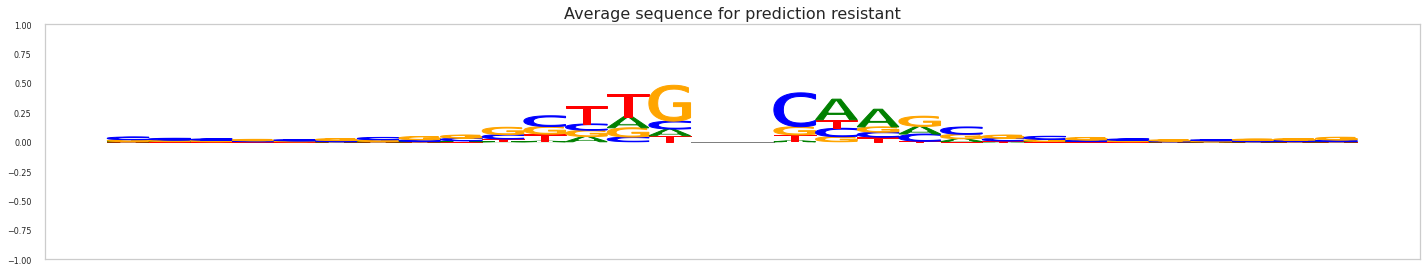

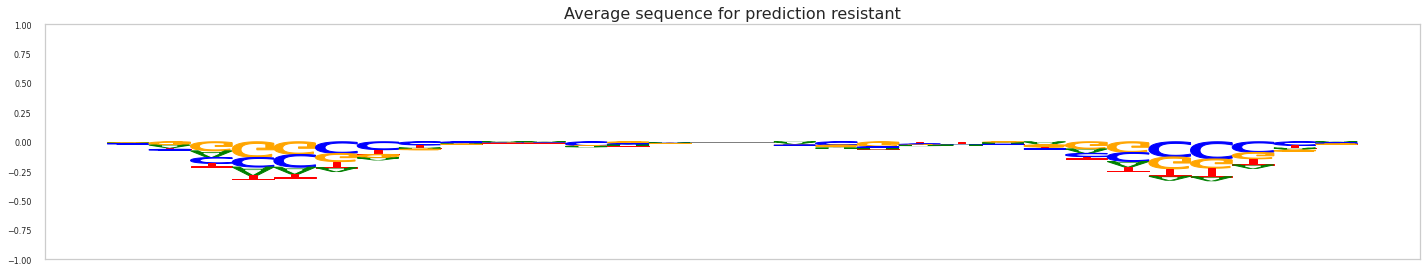

In [54]:
with open("./gradients_explain/graidnets_dictionary_zhou_top_10_all_low_density.pkl", "rb") as f:
  gradients_dictionary = pickle.load(f)

resist = gradients_dictionary["hypo-resistant"]
mean, std = np.mean(resist[resist>0]), np.std(resist[resist>0])
resist = resist>(mean+std)
# prone =gradients_dictionary["hypo-prone"] > 0.006306385

mean_seq = np.transpose(np.mean(resist[:, 60:90, :], axis=0).reshape(1, 30, 4), axes=(1, 2, 0))
# mean_seq = np.transpose(np.mean(resist[:, :, :], axis=0).reshape(1, 150, 4), axes=(1, 2, 0))

fig = seqlogo_fig(mean_seq, vocab="DNA", figsize=(20, 4), ncol=1,
                  plot_name="Average attribution score for prediction resist", yl=1)

ax = fig.axes[0]
ax.set_title("Average sequence for prediction resistant", fontsize=16)
fig.savefig("3_a_left_pos.pdf", bbox_inches='tight')



resist = gradients_dictionary["hypo-resistant"]
mean, std = np.mean(resist[resist<0]), np.std(resist[resist<0])
resist = resist<(mean-std)
# prone =gradients_dictionary["hypo-prone"] > 0.006306385

mean_seq = np.transpose(np.mean(-1*resist[:, 60:90, :], axis=0).reshape(1, 30, 4), axes=(1, 2, 0))
# mean_seq = np.transpose(np.mean(resist[:, :, :], axis=0).reshape(1, 150, 4), axes=(1, 2, 0))

fig = seqlogo_fig(mean_seq, vocab="DNA", figsize=(20, 4), ncol=1,
                  plot_name="Average attribution score for prediction resist", yl=1)

ax = fig.axes[0]
ax.set_title("Average sequence for prediction resistant", fontsize=16)
fig.savefig("3_a_left_neg.pdf", bbox_inches='tight')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:87: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:87: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


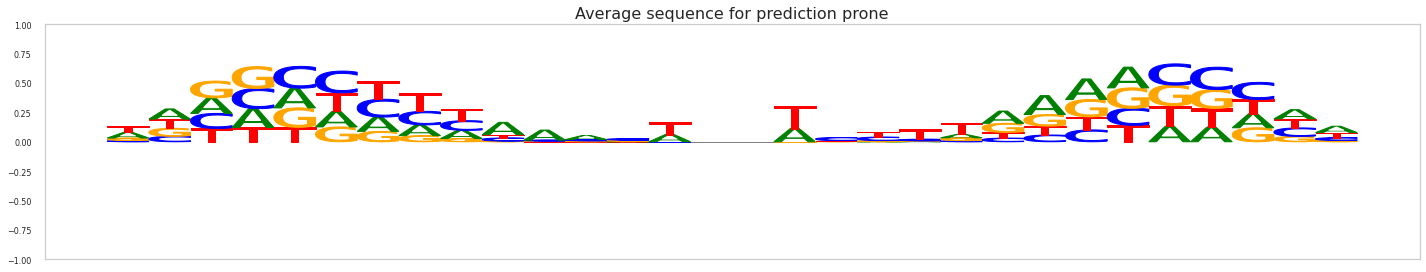

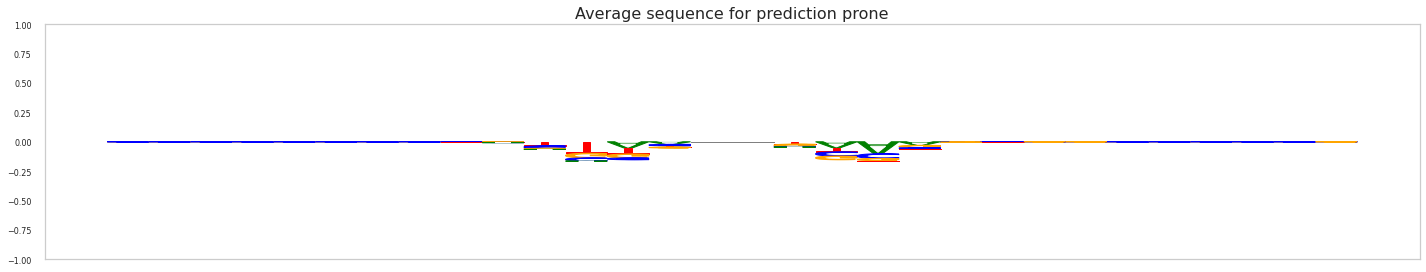

In [56]:
with open("./gradients_explain/graidnets_dictionary_zhou_top_10_all_low_density.pkl", "rb") as f:
  gradients_dictionary = pickle.load(f)

prone = gradients_dictionary["hypo-prone"]
mean, std = np.mean(prone[prone>0]), np.std(prone[prone>0])
prone = prone>(mean+std)
# prone =gradients_dictionary["hypo-prone"] > 0.006306385

mean_seq = np.transpose(np.mean(prone[:, 60:90, :], axis=0).reshape(1, 30, 4), axes=(1, 2, 0))
# mean_seq = np.transpose(np.mean(resist[:, :, :], axis=0).reshape(1, 150, 4), axes=(1, 2, 0))

fig = seqlogo_fig(mean_seq, vocab="DNA", figsize=(20, 4), ncol=1,
                  plot_name="Average attribution score for prediction prone", yl=1)

ax = fig.axes[0]
ax.set_title("Average sequence for prediction prone", fontsize=16)
fig.savefig("sup_3_b_left_pos.pdf", bbox_inches='tight')



prone = gradients_dictionary["hypo-prone"]
mean, std = np.mean(prone[prone<0]), np.std(prone[prone<0])
prone = prone<(mean-std)
# prone =gradients_dictionary["hypo-prone"] > 0.006306385

mean_seq = np.transpose(np.mean(-1*prone[:, 60:90, :], axis=0).reshape(1, 30, 4), axes=(1, 2, 0))
# mean_seq = np.transpose(np.mean(resist[:, :, :], axis=0).reshape(1, 150, 4), axes=(1, 2, 0))

fig = seqlogo_fig(mean_seq, vocab="DNA", figsize=(20, 4), ncol=1,
                  plot_name="Average attribution score for prediction prone", yl=1)

ax = fig.axes[0]
ax.set_title("Average sequence for prediction prone", fontsize=16)
fig.savefig("sup_3_b_left_neg.pdf", bbox_inches='tight')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:87: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:87: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


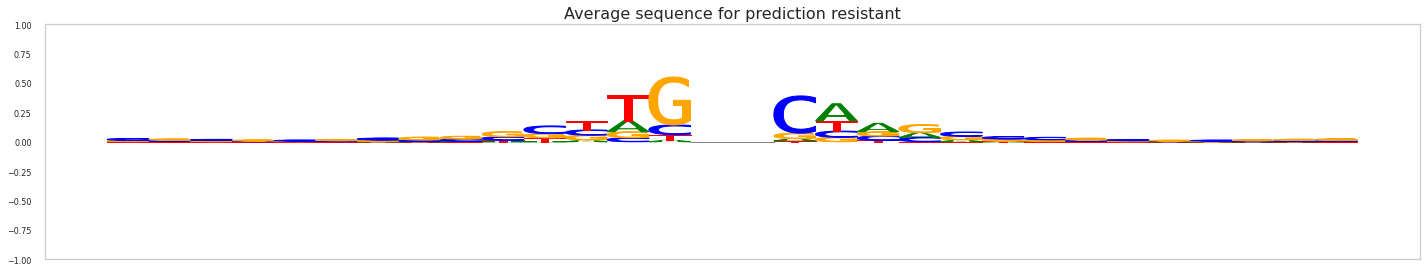

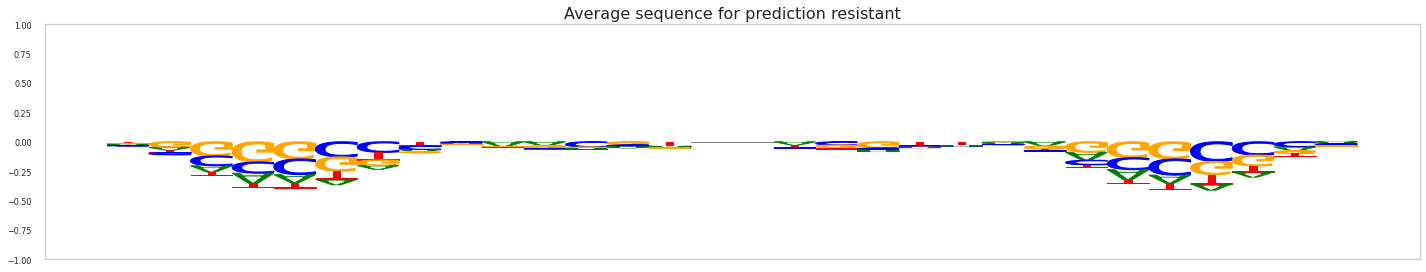

In [52]:
with open("./gradients_explain/graidnets_dictionary_bian_top_10_all_low_density.pkl", "rb") as f:
  gradients_dictionary = pickle.load(f)

resist = gradients_dictionary["hypo-resistant"]
mean, std = np.mean(resist[resist>0]), np.std(resist[resist>0])
resist = resist>(mean+std)
# prone =gradients_dictionary["hypo-prone"] > 0.006306385

mean_seq = np.transpose(np.mean(resist[:, 60:90, :], axis=0).reshape(1, 30, 4), axes=(1, 2, 0))
# mean_seq = np.transpose(np.mean(resist[:, :, :], axis=0).reshape(1, 150, 4), axes=(1, 2, 0))

fig = seqlogo_fig(mean_seq, vocab="DNA", figsize=(20, 4), ncol=1,
                  plot_name="Average attribution score for prediction resist", yl=1)

ax = fig.axes[0]
ax.set_title("Average sequence for prediction resistant", fontsize=16)
fig.savefig("3_a_right_pos.pdf", bbox_inches='tight')



resist = gradients_dictionary["hypo-resistant"]
mean, std = np.mean(resist[resist<0]), np.std(resist[resist<0])
resist = resist<(mean-std)
# prone =gradients_dictionary["hypo-prone"] > 0.006306385

mean_seq = np.transpose(np.mean(-1*resist[:, 60:90, :], axis=0).reshape(1, 30, 4), axes=(1, 2, 0))
# mean_seq = np.transpose(np.mean(resist[:, :, :], axis=0).reshape(1, 150, 4), axes=(1, 2, 0))

fig = seqlogo_fig(mean_seq, vocab="DNA", figsize=(20, 4), ncol=1,
                  plot_name="Average attribution score for prediction resist", yl=1)

ax = fig.axes[0]
ax.set_title("Average sequence for prediction resistant", fontsize=16)
fig.savefig("3_a_right_neg.pdf", bbox_inches='tight')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:87: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:87: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


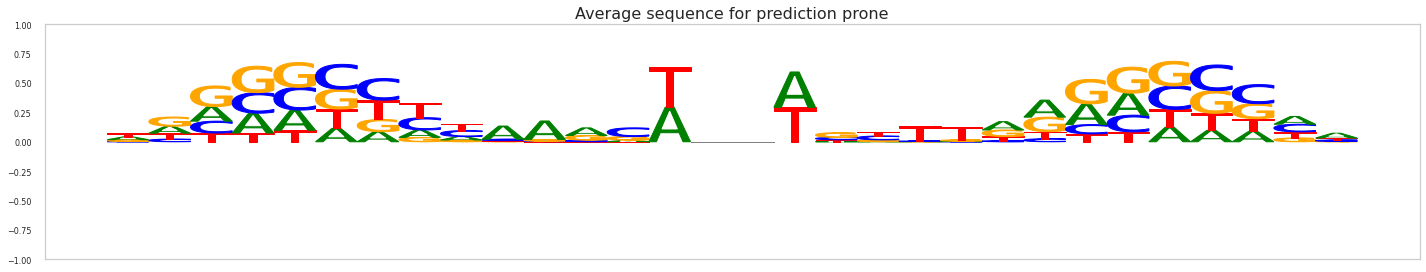

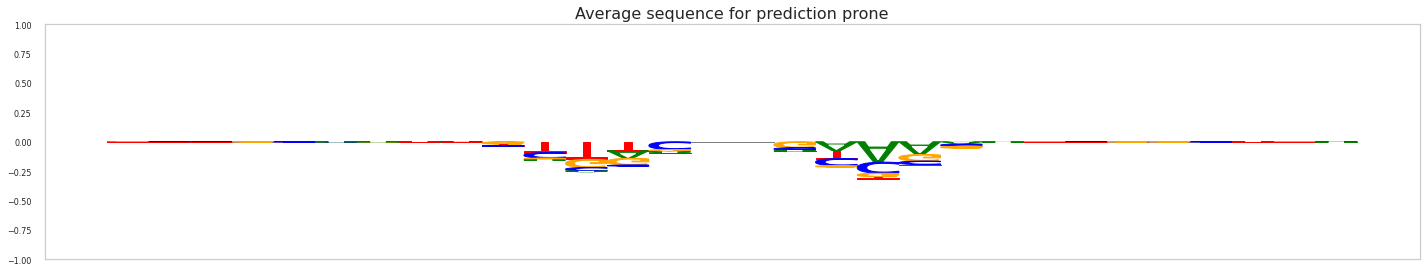

In [53]:
with open("./gradients_explain/graidnets_dictionary_bian_top_10_all_low_density.pkl", "rb") as f:
  gradients_dictionary = pickle.load(f)

prone = gradients_dictionary["hypo-prone"]
mean, std = np.mean(prone[prone>0]), np.std(prone[prone>0])
prone = prone>(mean+std)
# prone =gradients_dictionary["hypo-prone"] > 0.006306385

mean_seq = np.transpose(np.mean(prone[:, 60:90, :], axis=0).reshape(1, 30, 4), axes=(1, 2, 0))
# mean_seq = np.transpose(np.mean(resist[:, :, :], axis=0).reshape(1, 150, 4), axes=(1, 2, 0))

fig = seqlogo_fig(mean_seq, vocab="DNA", figsize=(20, 4), ncol=1,
                  plot_name="Average attribution score for prediction prone", yl=1)

ax = fig.axes[0]
ax.set_title("Average sequence for prediction prone", fontsize=16)
fig.savefig("sup_3_b_right_pos.pdf", bbox_inches='tight')



prone = gradients_dictionary["hypo-prone"]
mean, std = np.mean(prone[prone<0]), np.std(prone[prone<0])
prone = prone<(mean-std)
# prone =gradients_dictionary["hypo-prone"] > 0.006306385

mean_seq = np.transpose(np.mean(-1*prone[:, 60:90, :], axis=0).reshape(1, 30, 4), axes=(1, 2, 0))
# mean_seq = np.transpose(np.mean(resist[:, :, :], axis=0).reshape(1, 150, 4), axes=(1, 2, 0))

fig = seqlogo_fig(mean_seq, vocab="DNA", figsize=(20, 4), ncol=1,
                  plot_name="Average attribution score for prediction prone", yl=1)

ax = fig.axes[0]
ax.set_title("Average sequence for prediction prone", fontsize=16)
fig.savefig("sup_3_b_right_neg.pdf", bbox_inches='tight')

In [ ]:
# Plot individual sequences 
import tqdm


prone = []
resist = []

# Remove duplicates
seq = None

for i in range(gradients_dictionary["hypo-resistant"].shape[0]):
  new_seq = gradients_dictionary["hypo-resistant"][i]
  if np.all(new_seq == seq):
      continue
  else:
      resist.append(new_seq)
      seq = new_seq

seq = None
for i in range(gradients_dictionary["hypo-prone"].shape[0]):
  new_seq = gradients_dictionary["hypo-prone"][i]
  if np.all(new_seq == seq):
      continue
  else:
      prone.append(new_seq)
      seq = new_seq

# Plot
for i in tqdm.trange(200):
  fig = seqlogo_fig(resist[i], vocab="DNA", figsize=(30, 4), ncol=1, plot_name="hypo-resistant %s" %i)
  fig.savefig("./gradients_explain/orig_meth_larger_than_0.5/zhou_sequences/hypo-resistant/%s.png" %i)
  plt.close()

  fig = seqlogo_fig(prone[i], vocab="DNA", figsize=(30, 4), ncol=1, plot_name="hypo-prone %s" %i)
  fig.savefig("./gradients_explain/orig_meth_larger_than_0.5/zhou_sequences/hypo-prone/%s.png" %i)
  plt.close()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:87: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


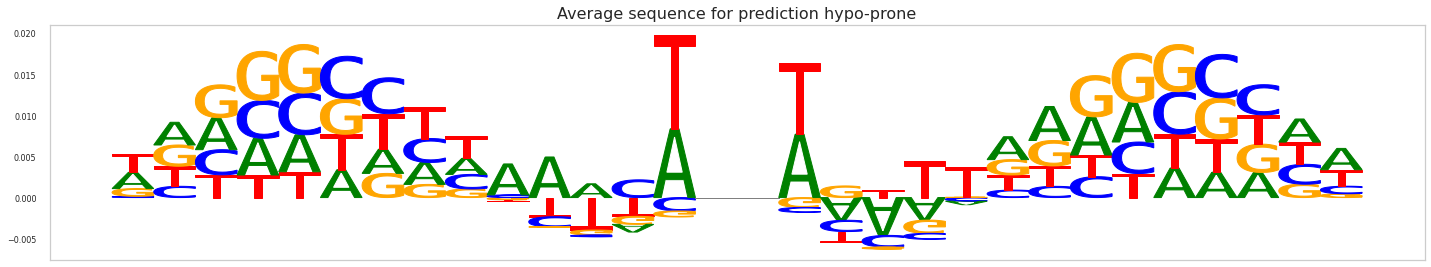

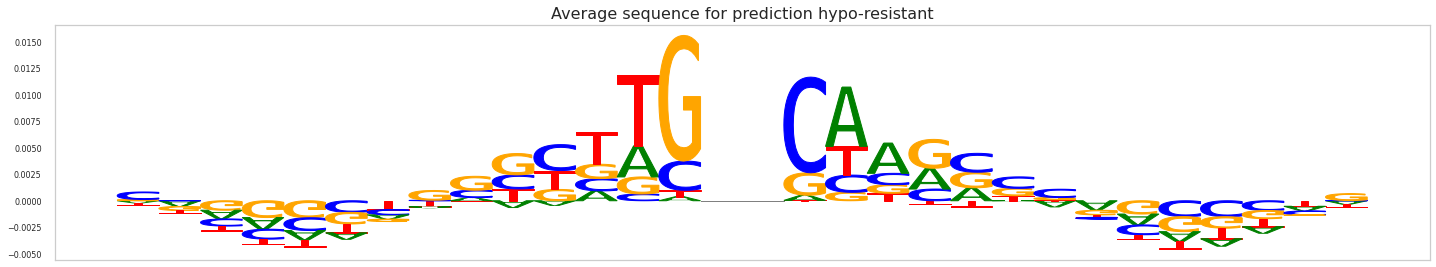

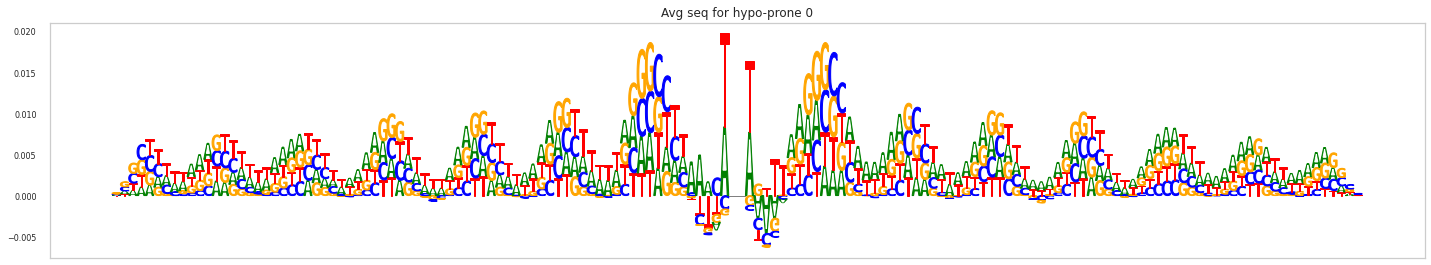

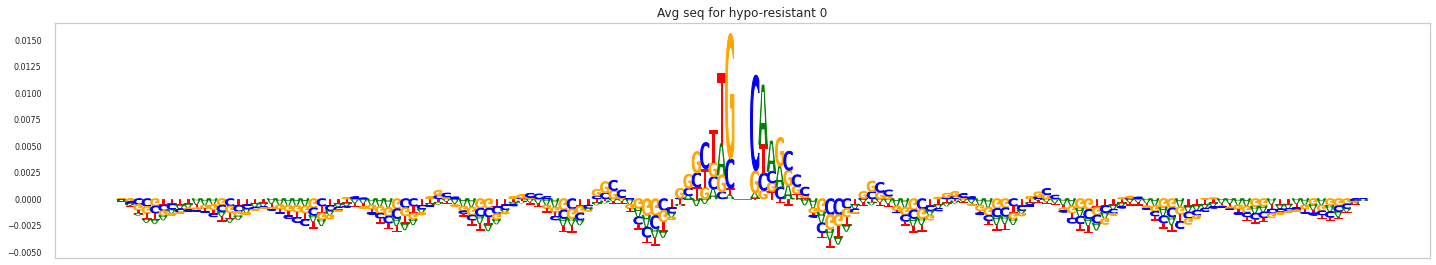

In [ ]:
with open("./gradients_explain/graidnets_dictionary_bian_top_10_all_low_density.pkl", "rb") as f:
  gradients_dictionary = pickle.load(f)

plot_avg_sequence(gradients_dictionary, prone_min=, resist_min = )

In [ ]:
# Plot individual sequences 
import tqdm


prone = []
resist = []

# Remove duplicates
seq = None

for i in range(gradients_dictionary["hypo-resistant"].shape[0]):
  new_seq = gradients_dictionary["hypo-resistant"][i]
  if np.all(new_seq == seq):
      continue
  else:
      resist.append(new_seq)
      seq = new_seq

seq = None
for i in range(gradients_dictionary["hypo-prone"].shape[0]):
  new_seq = gradients_dictionary["hypo-prone"][i]
  if np.all(new_seq == seq):
      continue
  else:
      prone.append(new_seq)
      seq = new_seq

# Plot
for i in tqdm.trange(200):
  fig = seqlogo_fig(resist[i], vocab="DNA", figsize=(30, 4), ncol=1, plot_name="hypo-resistant %s" %i)
  fig.savefig("./gradients_explain/orig_meth_larger_than_0.5/bian_sequences/hypo-resistant/%s.png" %i)
  plt.close()

  fig = seqlogo_fig(prone[i], vocab="DNA", figsize=(30, 4), ncol=1, plot_name="hypo-prone %s" %i)
  fig.savefig("./gradients_explain/orig_meth_larger_than_0.5/bian_sequences/hypo-prone/%s.png" %i)
  plt.close()

100%|██████████| 200/200 [02:35<00:00,  1.29it/s]


# Patterns  based on gradients - bian

In [36]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [ ]:
%%R
install.packages('Biostrings')
install.packages("BiocManager")

In [ ]:
from rpy2.robjects.packages import importr
import rpy2.robjects as ro

base = importr('base')
package_name = "BiocManager"

try:
    pkg = importr(package_name)
except:
    ro.r(f'install.packages("{package_name}")')
    pkg = importr(package_name)
pkg.install("Biostrings")
Biostrings = importr("Biostrings")


In [29]:
base = importr('base')

In [30]:
# search outside of main flank 
dataset = "bian"

with open("./gradients_explain/graidnets_dictionary_%s_top_10_all_low_density.pkl" % dataset, "rb") as f:
  gradients_dictionary = pickle.load(f)

resist_sequences = gradients_dictionary["hypo-resistant"]
prone_sequences = gradients_dictionary["hypo-prone"]

resist_sequences[:,69:81,:] = 0
prone_sequences[:,69:81,:] = 0

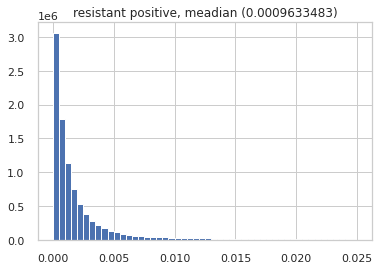

0.0009633483


In [ ]:
middle_value = np.median(resist_sequences[resist_sequences >0 ])
plt.hist(resist_sequences[resist_sequences >0], bins=50,range=(0,0.025))
plt.title("resistant positive, meadian (%s)" %middle_value)
plt.show()

print(middle_value)

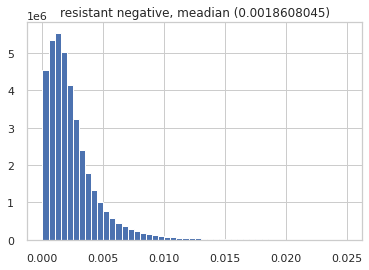

0.0018608045


In [ ]:
middle_value = np.median(resist_sequences[resist_sequences <0 ] * -1)
plt.hist(resist_sequences[resist_sequences <0] * -1, bins=50,range=(0,0.025))
plt.title("resistant negative, meadian (%s)" %middle_value)
plt.show()

print(middle_value)

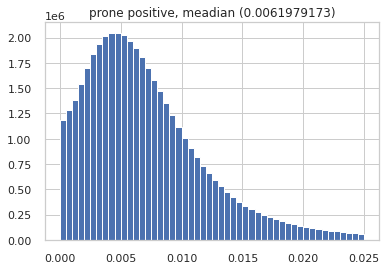

0.0061979173


In [ ]:
middle_value = np.median(prone_sequences[prone_sequences >0 ])
plt.hist(prone_sequences[prone_sequences >0], bins=50,range=(0,0.025))
plt.title("prone positive, meadian (%s)" %middle_value)
plt.show()

print(middle_value)

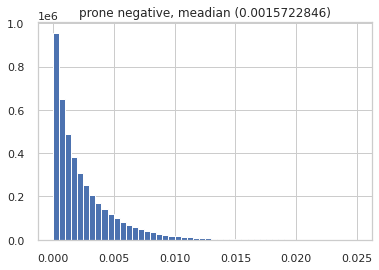

0.0015722846


In [ ]:
middle_value = np.median(prone_sequences[prone_sequences <0 ] * -1)
plt.hist(prone_sequences[prone_sequences <0] * -1, bins=50,range=(0,0.025))
plt.title("prone negative, meadian (%s)" %middle_value)
plt.show()

print(middle_value)

In [31]:
sequences_resist = convert_array_to_sequences(resist_sequences > 0.0009633483)
sequences_prone = convert_array_to_sequences(prone_sequences > 0.0061979173)

r_sequences_prone = base.unlist([str(i) for i in sequences_prone])
r_sequences_resist = base.unlist([str(i) for i in sequences_resist])


In [32]:

kmer4_freqs_prone = base.rowSums(base.sapply(Biostrings.DNAStringSet(r_sequences_prone), Biostrings.oligonucleotideFrequency, width=4, step=1))
kmer4_freqs_resist = base.rowSums(base.sapply(Biostrings.DNAStringSet(r_sequences_resist), Biostrings.oligonucleotideFrequency, width=4, step=1))

2020-10-06 09:04:00,006 [WARNING] R[write to console]: Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



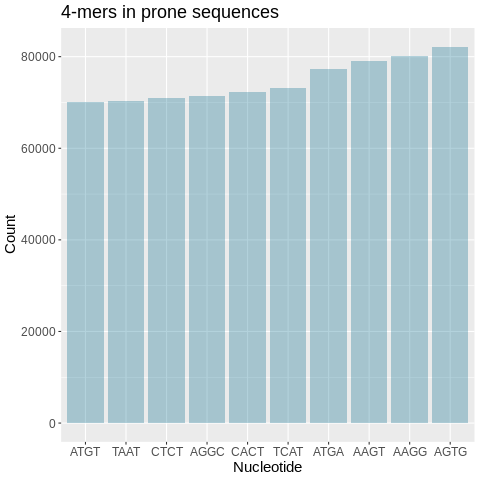

In [33]:
%%R -i kmer4_freqs_prone -i kmer4_freqs_resist
kmer4_freqs_prone = kmer4_freqs_prone 
library(ggplot2)
toplow.kmers <- kmer4_freqs_prone[order(kmer4_freqs_prone, decreasing=TRUE)[1:10]]
dflow <- data.frame(counts=toplow.kmers,kmer=names(toplow.kmers),label=rep("",length(toplow.kmers)))

dfall=rbind(dflow)

p1=  ggplot(dfall, aes(x=reorder(kmer, counts),y=counts,fill = label)) +
geom_bar( stat="identity", position = position_stack(reverse = TRUE)) + 
scale_y_continuous("Count") + ggtitle("4-mers in prone sequences") + 
labs(x = "Nucleotide")  + scale_fill_manual(values = alpha(c("deepskyblue4", "violetred4"), .3)) + theme(text = element_text(size=15))
p2= p1 + scale_fill_manual(name="",values = alpha(c("deepskyblue4", "violetred4"), .3)) + theme(legend.position="none")
print(p2)

2020-10-06 09:04:31,485 [WARNING] R[write to console]: Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.

2020-10-06 09:04:31,592 [WARNING] R[write to console]: Saving 6.67 x 6.67 in image



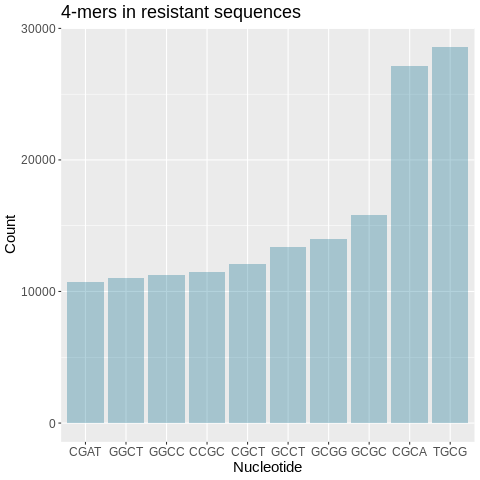

In [38]:
%%R -i kmer4_freqs_prone -i kmer4_freqs_resist
kmer4_freqs_resist = kmer4_freqs_resist 
library(ggplot2)
toplow.kmers <- kmer4_freqs_resist[order(kmer4_freqs_resist, decreasing=TRUE)[1:10]]
dflow <- data.frame(counts=toplow.kmers,kmer=names(toplow.kmers),label=rep("",length(toplow.kmers)))

dfall=rbind(dflow)

p1=  ggplot(dfall, aes(x=reorder(kmer, counts),y=counts,fill = label)) +
geom_bar( stat="identity", position = position_stack(reverse = TRUE)) + 
scale_y_continuous("Count") + ggtitle("4-mers in resistant sequences") + 
labs(x = "Nucleotide") + scale_fill_manual(values = alpha(c("deepskyblue4", "violetred4"), .3)) + theme(text = element_text(size=15))
p2= p1 + scale_fill_manual(name="",values = alpha(c("deepskyblue4", "violetred4"), .3)) + theme(legend.position="none")
print(p2)
ggsave("3_d_right.pdf")

2020-10-06 09:04:28,472 [WARNING] R[write to console]: Saving 6.67 x 6.67 in image



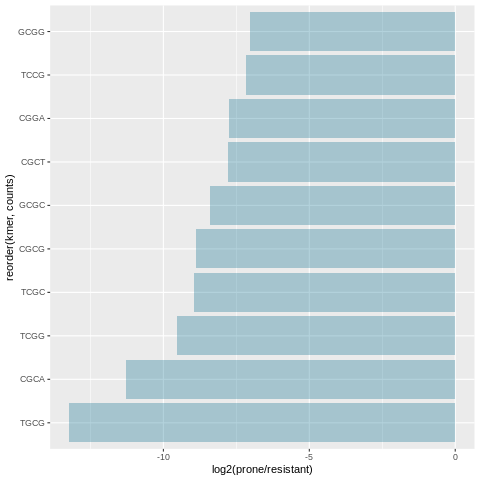

In [37]:
%%R -i kmer4_freqs_prone -i kmer4_freqs_resist
log2_prone_resist = log2(kmer4_freqs_prone / kmer4_freqs_resist)
library(ggplot2)
toplow.kmers <- log2_prone_resist[order(log2_prone_resist, decreasing=TRUE)[247:256]]
dflow <- data.frame(counts=toplow.kmers,kmer=names(toplow.kmers),label=rep("log2(Prone/Resistant)",length(toplow.kmers)))
 
# tophigh.kmers <- log2_prone_resist[order(log2_prone_resist, decreasing=TRUE)[1:10]]
# dfhigh <- data.frame(counts=tophigh.kmers,kmer=names(tophigh.kmers),label=rep("log2(Prone/Resistant)",length(tophigh.kmers)))

dfall=rbind(dflow)

p1=  ggplot(dfall, aes(x=reorder(kmer, counts),y=counts,fill = label)) +
geom_bar( stat="identity", position = position_stack(reverse = TRUE)) + 
scale_y_continuous("log2(prone/resistant)")  + coord_flip()
labs(x = "Nucleotide") + scale_fill_manual(values = alpha(c("deepskyblue4", "violetred4"), .3)) + theme(text = element_text(size=15))
p2= p1 + scale_fill_manual(name="",values = alpha(c("deepskyblue4", "violetred4"), .3)) + theme(legend.position="none")
print(p2)
ggsave("3_d_right_version2.pdf")

In [ ]:
kmer6_freqs_prone = base.rowSums(base.sapply(Biostrings.DNAStringSet(r_sequences_prone), Biostrings.oligonucleotideFrequency, width=6, step=1))
kmer6_freqs_resist = base.rowSums(base.sapply(Biostrings.DNAStringSet(r_sequences_resist), Biostrings.oligonucleotideFrequency, width=6, step=1))

In [ ]:
%%R -i kmer6_freqs_prone
library(ggplot2)
toplow.kmers <- kmer6_freqs_prone[order(kmer6_freqs_prone, decreasing=TRUE)[1:10]]
dflow <- data.frame(counts=toplow.kmers,kmer=names(toplow.kmers),label=rep("",length(toplow.kmers)))

dfall=rbind(dflow)

p1=  ggplot(dfall, aes(x=reorder(kmer, counts),y=counts,fill = label)) +
geom_bar( stat="identity", position = position_stack(reverse = TRUE)) + 
coord_flip() +  scale_y_continuous("Count") + 
labs(x = "Nucleotide") + scale_fill_manual(values = alpha(c("deepskyblue4", "violetred4"), .3)) + theme(text = element_text(size=15))
p2= p1 + scale_fill_manual(name="",values = alpha(c("deepskyblue4", "violetred4"), .3)) + theme(legend.position="none")
print(p2)

UsageError: Cell magic `%%R` not found.


In [ ]:
%%R -i kmer6_freqs_resist
library(ggplot2)
toplow.kmers <- kmer6_freqs_resist[order(kmer6_freqs_resist, decreasing=TRUE)[1:10]]
dflow <- data.frame(counts=toplow.kmers,kmer=names(toplow.kmers),label=rep("",length(toplow.kmers)))

dfall=rbind(dflow)

p1=  ggplot(dfall, aes(x=reorder(kmer, counts),y=counts,fill = label)) +
geom_bar( stat="identity", position = position_stack(reverse = TRUE)) + 
coord_flip() +  scale_y_continuous("Count") +
labs(x = "Nucleotide")  + scale_fill_manual(values = alpha(c("deepskyblue4", "violetred4"), .3)) + theme(text = element_text(size=15))
p2= p1 + scale_fill_manual(name="",values = alpha(c("deepskyblue4", "violetred4"), .3)) + theme(legend.position="none")
print(p2)

# Patterns  based on gradients - Zhou

In [17]:
%load_ext rpy2.ipython

/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex
/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:34: UserWarning: pandas >= 1.0 is not supported.
  warnings.warn('pandas >= 1.0 is not supported.')


In [18]:
%%R
install.packages('Biostrings')
install.packages("BiocManager")

2020-10-06 08:26:50,811 [WARNING] R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

2020-10-06 08:26:52,200 [WARNING] R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

2020-10-06 08:26:52,855 [WARNING] R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/BiocManager_1.30.10.tar.gz'

2020-10-06 08:26:53,079 [WARNING] R[write to console]: Content type 'application/x-gzip'
2020-10-06 08:26:53,080 [WARNING] R[write to console]:  length 40205 bytes (39 KB)

2020-10-06 08:26:53,082 [WARNING] R[write to console]: =
2020-10-06 08:26:53,083 [WARNING] R[write to console]: =
2020-10-06 08:26:53,084 [WARNING] R[write to console]: =
2020-10-06 08:26:53,087 [WARNING] R[write to console]: =
2020-10-06 08:26:53,089 [WARNING] R[write to console]: =
2020-10-06 08:26:53,089 [WARNING] R[write to console]: =
2020-10-06 08:26:53,090 [WARNING] R[write to console]: =
2020-10-06 08:26:53

In [19]:
from rpy2.robjects.packages import importr
import rpy2.robjects as ro

base = importr('base')
package_name = "BiocManager"

try:
    pkg = importr(package_name)
except:
    ro.r(f'install.packages("{package_name}")')
    pkg = importr(package_name)
pkg.install("Biostrings")
Biostrings = importr("Biostrings")


2020-10-06 08:26:57,171 [WARNING] R[write to console]: Bioconductor version 3.11 (BiocManager 1.30.10), R 4.0.2 (2020-06-22)

2020-10-06 08:26:57,173 [WARNING] R[write to console]: Installing package(s) 'BiocVersion', 'Biostrings'

2020-10-06 08:26:58,798 [WARNING] R[write to console]: also installing the dependencies ‘zlibbioc’, ‘BiocGenerics’, ‘S4Vectors’, ‘IRanges’, ‘XVector’


2020-10-06 08:26:58,801 [WARNING] R[write to console]: trying URL 'https://bioconductor.org/packages/3.11/bioc/src/contrib/zlibbioc_1.34.0.tar.gz'

2020-10-06 08:26:58,948 [WARNING] R[write to console]: Content type 'application/x-gzip'
2020-10-06 08:26:58,949 [WARNING] R[write to console]:  length 257122 bytes (251 KB)

2020-10-06 08:26:58,949 [WARNING] R[write to console]: =
2020-10-06 08:26:58,950 [WARNING] R[write to console]: =
2020-10-06 08:26:58,952 [WARNING] R[write to console]: =
2020-10-06 08:26:58,953 [WARNING] R[write to console]: =
2020-10-06 08:26:58,954 [WARNING] R[write to console]: =
2020-10-

In [20]:
base = importr('base')

In [21]:
# search outside of main flank 
dataset = "zhou"

with open("./gradients_explain/graidnets_dictionary_%s_top_10_all_low_density.pkl" % dataset, "rb") as f:
  gradients_dictionary = pickle.load(f)

resist_sequences = gradients_dictionary["hypo-resistant"]
prone_sequences = gradients_dictionary["hypo-prone"]


resist_sequences[:,69:81,:] = 0
prone_sequences[:,69:81,:] = 0

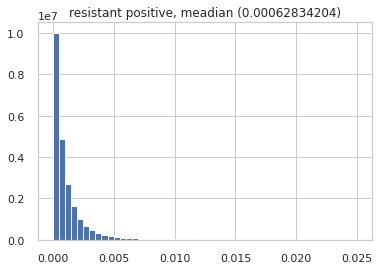

0.00062834204


In [ ]:
middle_value = np.median(resist_sequences[resist_sequences >0 ])
plt.hist(resist_sequences[resist_sequences >0], bins=50,range=(0,0.025))
plt.title("resistant positive, meadian (%s)" %middle_value)
plt.show()

print(middle_value)

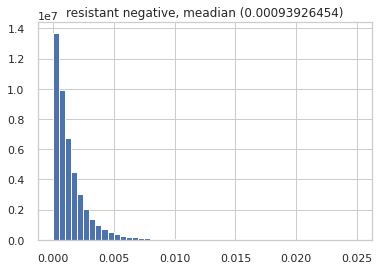

0.00093926454


In [ ]:
middle_value = np.median(resist_sequences[resist_sequences < 0 ] * -1) 
plt.hist(resist_sequences[resist_sequences <0] * -1, bins=50,range=(0,0.025))
plt.title("resistant negative, meadian (%s)" %middle_value)
plt.show()
print(middle_value)

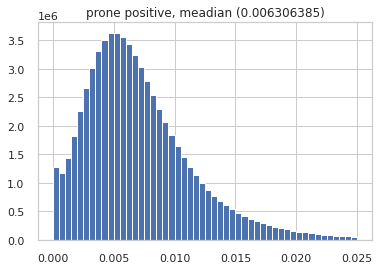

0.006306385


In [ ]:
middle_value = np.median(prone_sequences[prone_sequences >0 ])
plt.hist(prone_sequences[prone_sequences >0 ], bins=50,range=(0,0.025))
plt.title("prone positive, meadian (%s)" %middle_value)
plt.show()
print(middle_value)

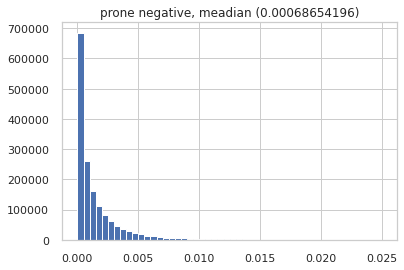

0.00068654196


In [ ]:
middle_value = np.median(prone_sequences[prone_sequences <0 ] * -1)
plt.hist(prone_sequences[prone_sequences <0 ] * -1, bins=50,range=(0,0.025))
plt.title("prone negative, meadian (%s)" %middle_value)
plt.show()
print(middle_value)

In [22]:
sequences_resist = convert_array_to_sequences(resist_sequences > 0.00062834204)
sequences_prone = convert_array_to_sequences(prone_sequences > 0.006306385)

r_sequences_prone = base.unlist([str(i) for i in sequences_prone])
r_sequences_resist = base.unlist([str(i) for i in sequences_resist])

kmer4_freqs_prone = base.rowSums(base.sapply(Biostrings.DNAStringSet(r_sequences_prone), Biostrings.oligonucleotideFrequency, width=4, step=1))
kmer4_freqs_resist = base.rowSums(base.sapply(Biostrings.DNAStringSet(r_sequences_resist), Biostrings.oligonucleotideFrequency, width=4, step=1))

2020-10-06 08:47:22,537 [WARNING] R[write to console]: Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.

2020-10-06 08:47:22,640 [WARNING] R[write to console]: Saving 6.67 x 6.67 in image



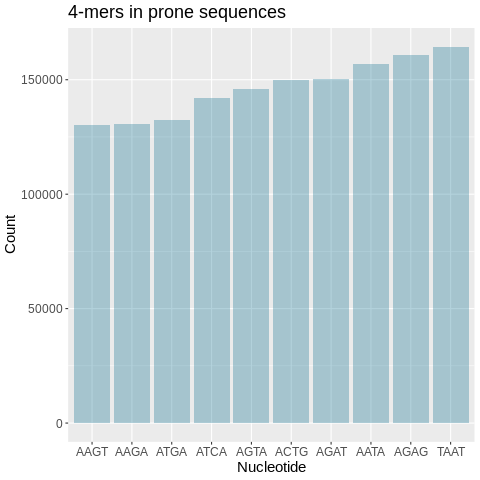

In [25]:
%%R -i kmer4_freqs_prone -i kmer4_freqs_resist
kmer4_freqs_prone = kmer4_freqs_prone 
library(ggplot2)
toplow.kmers <- kmer4_freqs_prone[order(kmer4_freqs_prone, decreasing=TRUE)[1:10]]
dflow <- data.frame(counts=toplow.kmers,kmer=names(toplow.kmers),label=rep("",length(toplow.kmers)))

dfall=rbind(dflow)

p1=  ggplot(dfall, aes(x=reorder(kmer, counts),y=counts,fill = label)) +
geom_bar( stat="identity", position = position_stack(reverse = TRUE)) + 
scale_y_continuous("Count") + ggtitle("4-mers in prone sequences") + 
labs(x = "Nucleotide")  + scale_fill_manual(values = alpha(c("deepskyblue4", "violetred4"), .3)) + theme(text = element_text(size=15))
p2= p1 + scale_fill_manual(name="",values = alpha(c("deepskyblue4", "violetred4"), .3)) + theme(legend.position="none")
print(p2)
ggsave("3_d_left.pdf")

2020-10-06 08:48:39,290 [WARNING] R[write to console]: Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.

2020-10-06 08:48:39,386 [WARNING] R[write to console]: Saving 6.67 x 6.67 in image



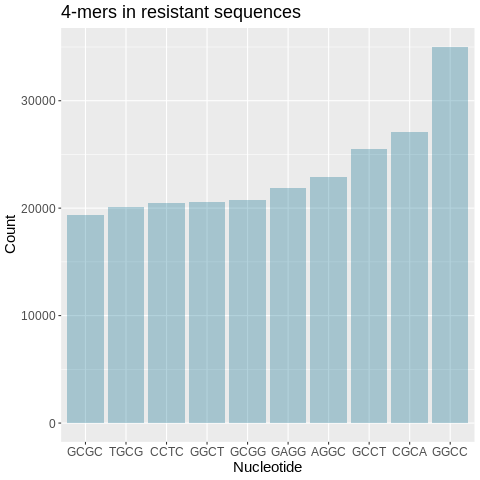

In [27]:
%%R -i kmer4_freqs_prone -i kmer4_freqs_resist
kmer4_freqs_resist = kmer4_freqs_resist 
library(ggplot2)
toplow.kmers <- kmer4_freqs_resist[order(kmer4_freqs_resist, decreasing=TRUE)[1:10]]
dflow <- data.frame(counts=toplow.kmers,kmer=names(toplow.kmers),label=rep("",length(toplow.kmers)))

dfall=rbind(dflow)

p1=  ggplot(dfall, aes(x=reorder(kmer, counts),y=counts,fill = label)) +
geom_bar( stat="identity", position = position_stack(reverse = TRUE)) + 
scale_y_continuous("Count") + ggtitle("4-mers in resistant sequences") + 
labs(x = "Nucleotide") + scale_fill_manual(values = alpha(c("deepskyblue4", "violetred4"), .3)) + theme(text = element_text(size=15))
p2= p1 + scale_fill_manual(name="",values = alpha(c("deepskyblue4", "violetred4"), .3)) + theme(legend.position="none")
print(p2)
ggsave("3_d_left.pdf")

2020-10-06 08:50:38,637 [WARNING] R[write to console]: Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.

2020-10-06 08:50:38,731 [WARNING] R[write to console]: Saving 6.67 x 6.67 in image



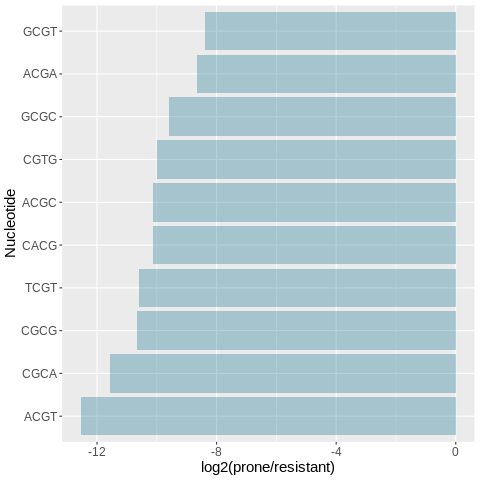

In [28]:
%%R -i kmer4_freqs_prone -i kmer4_freqs_resist
log2_prone_resist = log2(kmer4_freqs_prone / kmer4_freqs_resist)
library(ggplot2)
toplow.kmers <- log2_prone_resist[order(log2_prone_resist, decreasing=TRUE)[247:256]]
dflow <- data.frame(counts=toplow.kmers,kmer=names(toplow.kmers),label=rep("log2(Prone/Resistant)",length(toplow.kmers)))

# tophigh.kmers <- log2_prone_resist[order(log2_prone_resist, decreasing=TRUE)[1:10]]
# dfhigh <- data.frame(counts=tophigh.kmers,kmer=names(tophigh.kmers),label=rep("log2(Prone/Resistant)",length(tophigh.kmers)))

dfall=rbind(dflow)

p1=  ggplot(dfall, aes(x=reorder(kmer, counts),y=counts,fill = label)) +
geom_bar( stat="identity", position = position_stack(reverse = TRUE)) + 
scale_y_continuous("log2(prone/resistant)") + coord_flip() + 
labs(x = "Nucleotide") + scale_fill_manual(values = alpha(c("deepskyblue4", "violetred4"), .3)) + theme(text = element_text(size=15))
p2= p1 + scale_fill_manual(name="",values = alpha(c("deepskyblue4", "violetred4"), .3)) + theme(legend.position="none")
print(p2)
ggsave("3_d_left_version2.pdf")

In [ ]:
r_sequences_prone = base.unlist([str(i) for i in sequences_prone])
r_sequences_resist = base.unlist([str(i) for i in sequences_resist])

kmer6_freqs_prone = base.rowSums(base.sapply(Biostrings.DNAStringSet(r_sequences_prone), Biostrings.oligonucleotideFrequency, width=6, step=1))
kmer6_freqs_resist = base.rowSums(base.sapply(Biostrings.DNAStringSet(r_sequences_resist), Biostrings.oligonucleotideFrequency, width=6, step=1))

From cffi callback <function _processevents at 0x7f5f6f78c6a8>:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/rpy2/rinterface_lib/callbacks.py", line 262, in _processevents
    @ffi_proxy.callback(ffi_proxy._processevents_def,
KeyboardInterrupt
From cffi callback <function _processevents at 0x7f5f6f78c6a8>:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/rpy2/rinterface_lib/callbacks.py", line 262, in _processevents
    @ffi_proxy.callback(ffi_proxy._processevents_def,
KeyboardInterrupt
From cffi callback <function _processevents at 0x7f5f6f78c6a8>:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/rpy2/rinterface_lib/callbacks.py", line 262, in _processevents
    @ffi_proxy.callback(ffi_proxy._processevents_def,
KeyboardInterrupt


In [ ]:
%%R -i kmer6_freqs_prone
library(ggplot2)
toplow.kmers <- kmer6_freqs_prone[order(kmer6_freqs_prone, decreasing=TRUE)[1:15]]
dflow <- data.frame(counts=toplow.kmers,kmer=names(toplow.kmers),label=rep("",length(toplow.kmers)))

dfall=rbind(dflow)

p1=  ggplot(dfall, aes(x=reorder(kmer, counts),y=counts,fill = label)) +
geom_bar( stat="identity", position = position_stack(reverse = TRUE)) + 
coord_flip() +  scale_y_continuous("Count") + 
labs(x = "Nucleotide") + scale_fill_manual(values = alpha(c("deepskyblue4", "violetred4"), .3)) + theme(text = element_text(size=15))
p2= p1 + scale_fill_manual(name="",values = alpha(c("deepskyblue4", "violetred4"), .3)) + theme(legend.position="none")
print(p2)

In [ ]:
%%R -i kmer6_freqs_resist
library(ggplot2)
toplow.kmers <- kmer6_freqs_resist[order(kmer6_freqs_resist, decreasing=TRUE)[1:15]]
dflow <- data.frame(counts=toplow.kmers,kmer=names(toplow.kmers),label=rep("",length(toplow.kmers)))

dfall=rbind(dflow)

p1=  ggplot(dfall, aes(x=reorder(kmer, counts),y=counts,fill = label)) +
geom_bar( stat="identity", position = position_stack(reverse = TRUE)) + 
coord_flip() +  scale_y_continuous("Count") +
labs(x = "Nucleotide")  + scale_fill_manual(values = alpha(c("deepskyblue4", "violetred4"), .3)) + theme(text = element_text(size=15))
p2= p1 + scale_fill_manual(name="",values = alpha(c("deepskyblue4", "violetred4"), .3)) + theme(legend.position="none")
print(p2)

# Gradients of shared sequences 

In [9]:
with open("./gradients_explain/graidnets_dictionary_bian_top_10_all_low_density.pkl", "rb") as f:
  gradients_dictionary = pickle.load(f)

bian_resist = gradients_dictionary["hypo-resistant"]

with open("./gradients_explain/graidnets_dictionary_zhou_top_10_all_low_density.pkl", "rb") as f:
  gradients_dictionary = pickle.load(f)

zhou_resist = gradients_dictionary["hypo-resistant"]

In [10]:
sequences_zhou = convert_array_to_sequences(zhou_resist !=0)
sequences_bian = convert_array_to_sequences(bian_resist !=0)
combine = set(sequences_bian) & set(sequences_zhou)
indexes = [(sequences_bian.index(i), sequences_zhou.index(i)) for i in combine]


In [11]:
cgca_sequences  = [i for i in range(len(sequences_bian)) if sequences_bian[i].count("CGCA") > 1]
combine_in = [i for i in range(len(indexes)) if indexes[i][0] in cgca_sequences]

/gdrive/My Drive/nn/plotseqlogo.py:180: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], [])


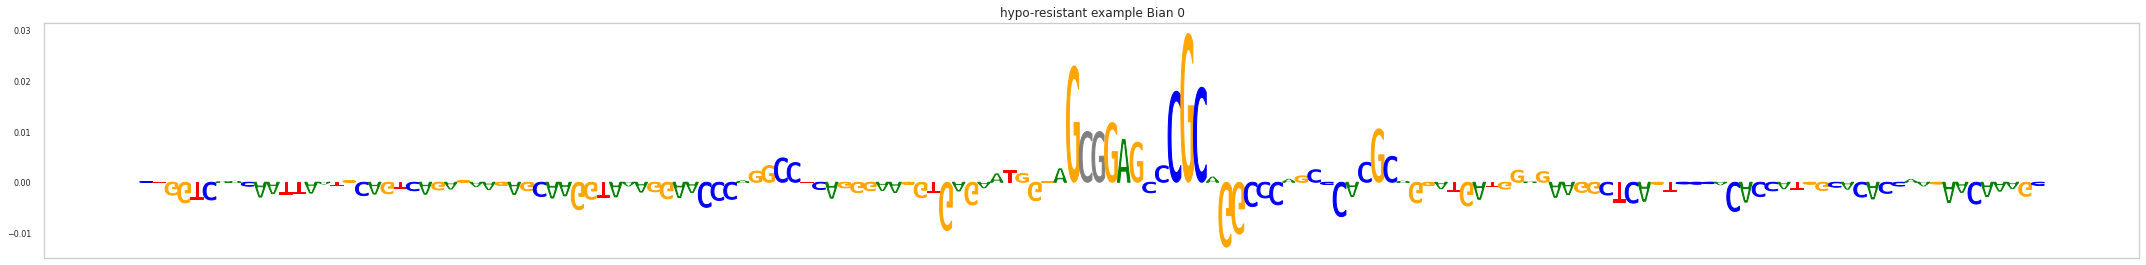

In [14]:
f = seqlogo_fig(bian_resist[indexes[combine_in[2]][0]], vocab="DNA", figsize=(30, 4), ncol=1, plot_name="hypo-resistant example Bian")

In [15]:
f.savefig("3_c_right.pdf", bbox_inches='tight')

/gdrive/My Drive/nn/plotseqlogo.py:180: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], [])


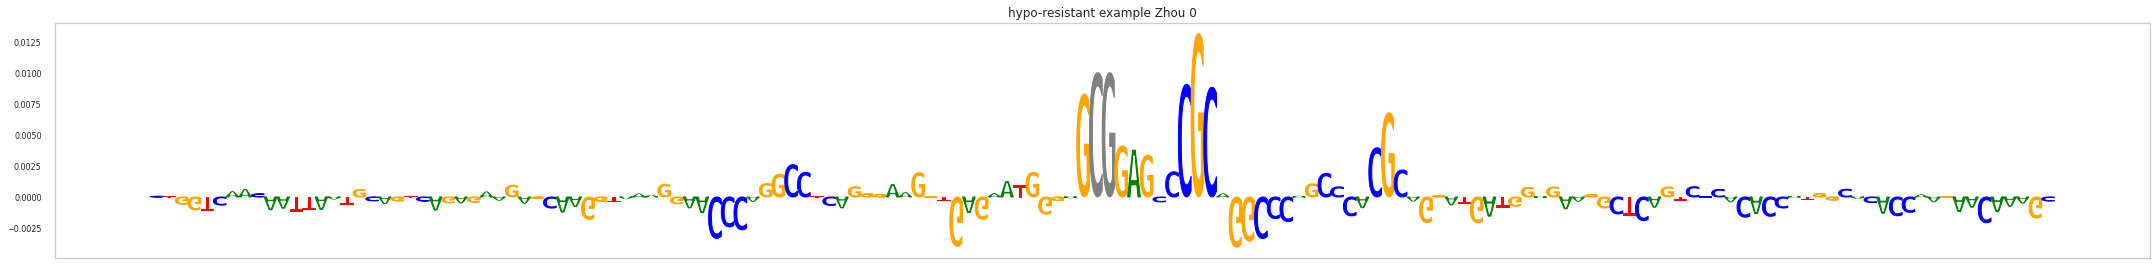

In [16]:
f = seqlogo_fig(zhou_resist[indexes[combine_in[2]][1]], vocab="DNA", figsize=(30, 4), ncol=1, plot_name="hypo-resistant example Zhou")
f.savefig("3_c_left.pdf", bbox_inches='tight')

In [ ]:
seq =sequences_zhou[indexes[combine_in[2]][1]]

In [ ]:
seq = list(seq)
seq[74] = "C"
seq[75] = "G"
seq = "".join(seq)

In [ ]:
# Get prediction score 
zhou_models = load_models(zhou_models_folder)
bian_models = load_models(sc_models_folder)


vec = np.array([seq_to_mat(seq) for seq in [seq]])
print("Prediction of sequence by zhou model: %s, by bian model %s" %(predict(zhou_models, vec),predict(bian_models, vec)))

Prediction of sequence by zhou model: [0.00735735], by bian model [0.11958897]


In [ ]:
import pandas as pd
zhou_dataset = pd.read_pickle("./dataset/zhou_pmds_with_pred_top_bottom_10.pkl")



In [ ]:
zhou_dataset[zhou_dataset["sequence"] == seq ]

,index,location,chromosome,meth,var,pearson_corr,coveriance,orig_meth,sequence,pmd_index,pred,reverse_pred,ccpg
4565399,327849,131790373,chr7,0.91775,0.014878,0.458999,0.006905,0.928223,CAATTCCATCACAGCAAGAAGGCTGGACATAAGCATCTCCTTTCAG...,71,0.007357,0.008664,3


# Plot avg based on cutoff

In [ ]:
!pip install logomaker

     |████████████████████████████████| 11.8MB 257kB/s 


In [ ]:
import logomaker
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
with open("./gradients_explain/all/graidnets_dictionary_zhou_top_10_all_low_density.pkl", "rb") as f:
  gradients_dictionary = pickle.load(f)


resist_sequences = gradients_dictionary["hypo-resistant"]
prone_sequences = gradients_dictionary["hypo-prone"]


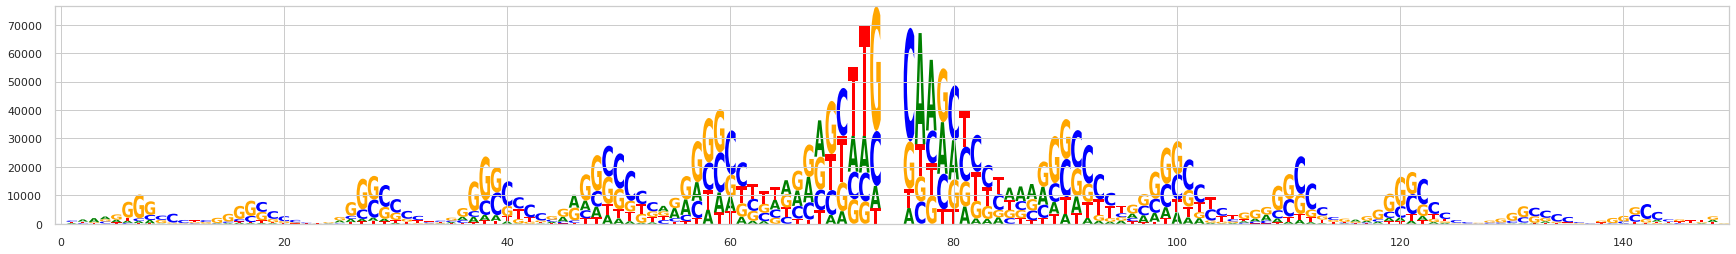

In [ ]:
resist_array = resist_sequences > 0.00016208392
resist_array = resist_array.astype(np.int).sum(axis=0)

df_resist = pd.DataFrame()
df_resist["A"] = resist_array[:,0]
df_resist["C"] = resist_array[:,1]
df_resist["G"] = resist_array[:,2]
df_resist["T"] = resist_array[:,3]

logomaker.Logo(df_resist, figsize=(30,4))

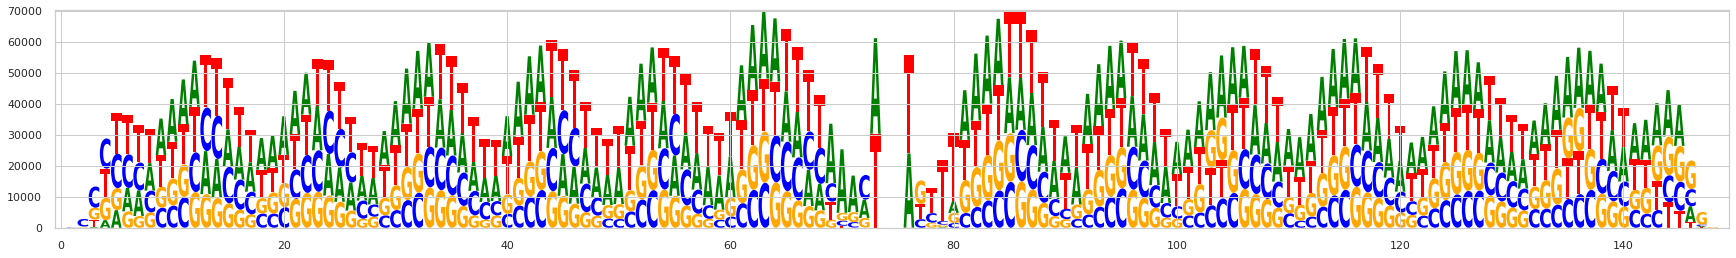

In [ ]:
prone_array = prone_sequences > 0.0063648755
prone_array = prone_array.astype(np.int).sum(axis=0)

df_prone = pd.DataFrame()
df_prone["A"] = prone_array[:,0]
df_prone["C"] = prone_array[:,1]
df_prone["G"] = prone_array[:,2]
df_prone["T"] = prone_array[:,3]

logomaker.Logo(df_prone, figsize=(30,4))

In [ ]:
with open("./gradients_explain/all/graidnets_dictionary_bian.pkl", "rb") as f:
  gradients_dictionary = pickle.load(f)


resist_sequences = gradients_dictionary["hypo-resistant"]
prone_sequences = gradients_dictionary["hypo-prone"]
middle_value = 0.002

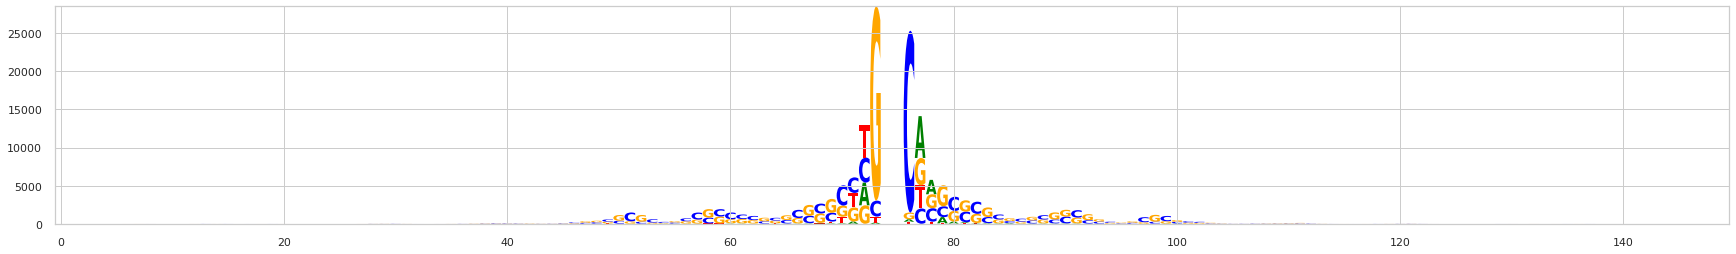

In [ ]:
resist_array = resist_sequences > 0.015
resist_array = resist_array.astype(np.int).sum(axis=0)

df_resist = pd.DataFrame()
df_resist["A"] = resist_array[:,0]
df_resist["C"] = resist_array[:,1]
df_resist["G"] = resist_array[:,2]
df_resist["T"] = resist_array[:,3]

logomaker.Logo(df_resist, figsize=(30,4))

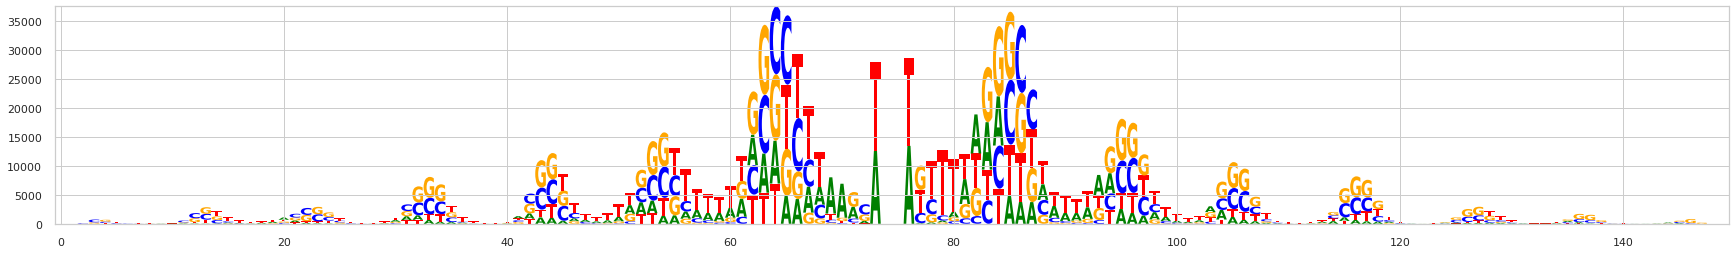

In [ ]:
prone_array = prone_sequences > 0.015
prone_array = prone_array.astype(np.int).sum(axis=0)

df_prone = pd.DataFrame()
df_prone["A"] = prone_array[:,0]
df_prone["C"] = prone_array[:,1]
df_prone["G"] = prone_array[:,2]
df_prone["T"] = prone_array[:,3]

logomaker.Logo(df_prone, figsize=(30,4))